# Biomarker Identification

In [1]:
# adding the project root inside the python path
import sys
import os

sys.path.insert(0, os.path.abspath('..'))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from bioinfokit import visuz
from analysis.preprocess import PreprocessPipeline

In [3]:
pipeline = PreprocessPipeline(
    datasets_path='../../dataset/first_disease_sel',
    disease_col_name='DISEASE',
    output_dir='/tmp/chl/',
)

pipeline.execute_pipeline()
df = pipeline.dataset

INFO:root:Starting pipeline
INFO:root:Loading datasets
INFO:root:Inspecting directory ../../dataset/first_disease_sel/GS
INFO:root:Setting disease as GS
INFO:root:Loading file ../../dataset/first_disease_sel/GS/eGSE117146m.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/MCM
INFO:root:Setting disease as MCM
INFO:root:Loading file ../../dataset/first_disease_sel/MCM/MCM_GSE149607.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/NALD
INFO:root:Setting disease as NALD
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE85804m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE34308m.csv
INFO:root:Loading file ../../dataset/first_disease_sel/NALD/eGSE117647m.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/A1A
INFO:root:Setting disease as A1A
INFO:root:Loading file ../../dataset/first_disease_sel/A1A/A1A_deficiency_GSE109516_pbmc.csv
INFO:root:Inspecting directory ../../dataset/first_disease_sel/DIABETE
INFO

In [ ]:
pipeline.test_set

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
# Change rownames considering patient groups
new_index_names = []
tmp = ''
j = 1
for i in range(df.shape[0]):
    disease = df.loc[i,'DISEASE']
    if tmp != disease:
        tmp = disease
        j = 1
        new_index_names.append(tmp+'_'+str(j))
    else:
        new_index_names.append(tmp+'_'+str(j))
        j += 1
        
df.set_axis(new_index_names, axis=0, inplace=True)

## Inspecting dataset we have built

In [ ]:
# plotting the number of sample for each disease
disease = df['DISEASE'].value_counts()
print(disease)
disease.plot.bar()

# Analysis

In [ ]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']

In [ ]:
visuz.gene_exp.hmap(df=df[data_cols], cmap='viridis', rowclus=False, colclus=False, dim=(10, 10), tickfont=(3, 2), show=True)

In [ ]:
gene = 'SEC23IP'
plt.hist(df.loc[df['DISEASE']=='GS', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='MCM', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='A1A', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='DIABETE', gene], bins=10, alpha=0.5)
plt.hist(df.loc[df['DISEASE']=='NALD', gene], bins=10, alpha=0.5)

plt.title(gene+' gene histogram')  
plt.legend(['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'])
  
plt.show()

## Biomarker Identification pipeline

1. Pairwise statistical test
2. Gene selection for each pair of disease
3. Gene intersection

In [ ]:
from collections.abc import Callable
import itertools
def pairwise_hyp_testing(df: pd.DataFrame, disease_col: str, diseases: list[str], 
                         test: Callable[[pd.Series, pd.Series], float]) -> dict[tuple[str,str], list[float]]:
    """
    This function computes the pairwise hypothesis testing between diseases.
    :param df: dataframe with expression levels
    :param disease_col: the name of the column where the type of disease is represented
    :param diseases: a list of diseases to test
    :param test: the function of the testing
    :return dictionary of pairwise test. Example: ('DIABETE', 'A1A') -> [test_gene1, test_gene2,..., test_geneN]
    """
    combinations = list(itertools.combinations(diseases, 2))
    pairwise_test = dict()
    
    for pair in combinations:
        df1 = df[df[disease_col]==pair[0]].copy()
        df1.drop(disease_col, axis=1, inplace=True)
        df2 = df[df[disease_col]==pair[1]].copy()
        df2.drop(disease_col, axis=1, inplace=True)
        pair_test = []
        
        for gene in df1:
            gene_test = test(df1[gene], df2[gene])
            pair_test.append(gene_test)
        
        pairwise_test[pair] = pair_test
    
    return pairwise_test


In [ ]:
from scipy.stats import ttest_ind
def t_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the t-test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pvalue
    """
    # ttest_ind returns tuple(statistic, pvalue)
    return ttest_ind(s1, s2)[1]

In [ ]:
import math
def log2fc(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the log-fold change between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return log2-Fold Change
    """
    return math.log(s1.mean()/s2.mean(), 2)

In [ ]:
from scipy.stats import ranksums
def wilcoxon_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the Wilcoxon's test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pValue of Wilcoxon's test
    """
    return ranksums(s1, s2)[1]

In [ ]:
from scipy.stats import ks_2samp
def ks_test(s1: pd.Series, s2: pd.Series) -> float:
    """
    This function computes the Kolmogorov-Smirnov test between two groups of patients for one gene
    :param s1: expression gene of one patient (one gene)
    :param s2: expression gene of another patient (one gene)
    :return pValue of KS test
    """
    return ks_2samp(s1, s2)[1]

In [ ]:
import math
def gene_selection(stat_test: dict[tuple[str,str], list[float]], gene_names: list[str], 
                   alpha: float, correction: str = None, log2fc: dict[tuple[str,str], list[float]] = None,
                  log2fc_thr: float = None)-> dict[tuple[str,str], list[str]]:
    """
    This function selects genes for each pair of diseases based on a given threshold, eventually with correction.
    :param stat_test: dictionary with pvalues of pairwise tests 
                        Example of entry ('Disease1', 'Disease2') -> [pValues_gene1,...,pValues_geneN]
    :param gene_names: list of gene names. This list MUST have the same length of each value of the dictionary
                        and the same order
    :param alpha: the significance to test the pValue
    :param correction: type of correction to apply to the filter. 
                        Possible values ['bonferroni', '2fc', None]
                        'bonferroni': Bonferroni correction
                        '2fc': log2FC - pValue selection. It requires log2fc and log2fc_thr parameters
                        None: by default negative log10 comparison
    :param log2fc: dictionary with log2fc of pairwise tests. Needed if correction='2fc'. MUST have the same length
                    and order of gene_names.
    :param log2fc_thr: threshold for log2fc. Needed if correction='2fc'
    :return dictionary with filtered genes by pValues
    """
    a = alpha
    f = lambda pVal: -math.log(pVal,10)
    # Check if you have to compare log2FC with pValue
    volcano = False
    threshold_check = lambda pVal, alpha: pVal > alpha
    
    # Arguments validation
    if correction == 'bonferroni':
        a = f(a/len(stat_test))
    elif correction == '2fc':
        if log2fc == None or log2fc_thr == None:
            raise ValueError("Correction='2fc', you must define log2fc and log2fc_thr")
        else:
            a = f(a)
            threshold_check = lambda pVal, alpha, l2fc, l2fc_thr: pVal > alpha and abs(l2fc) > l2fc_thr
            volcano = True
    else:
        a = f(a)
        
    
    pairwise_genes_dict = {}
    for key, value in stat_test.items():
        selected_genes = []
        # Double comparison log2fc - pvalue
        if volcano:
            curr_log2fc = log2fc[key]
            for i in range(len(value)):
                if threshold_check(f(value[i]), a, curr_log2fc[i], log2fc_thr):
                    selected_genes.append(gene_names[i])
        # Comparison of pvalue
        else: 
            for i in range(len(value)):
                if threshold_check(f(value[i]), a):
                    selected_genes.append(gene_names[i])
        pairwise_genes_dict[key] = selected_genes
    
    return pairwise_genes_dict

In [ ]:
def gene_intersection(pairwise_genes: dict[tuple[str,str], list[str]]) -> list[str]:
    """
    This function computes the intersection between list of genes
    :param pairwise_genes: dictionary with pairwised diseases and list of genes
    :return intersection between genes
    """
    intersection = []
    first = True
    for key, value in pairwise_genes.items():
        if not first:
            intersection = [gene for gene in intersection if gene in value]
        else:
            intersection = value
            first=False
        print(len(intersection))
    return intersection

## Test

In [ ]:
import itertools
diseases = ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']
combinations = list(itertools.combinations(diseases, 2))
combinations

In [16]:
import itertools
diseases = ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD']
combinations = list(itertools.combinations(diseases, 2))
combinations

[('GS', 'MCM'),
 ('GS', 'A1A'),
 ('GS', 'DIABETE'),
 ('GS', 'NALD'),
 ('MCM', 'A1A'),
 ('MCM', 'DIABETE'),
 ('MCM', 'NALD'),
 ('A1A', 'DIABETE'),
 ('A1A', 'NALD'),
 ('DIABETE', 'NALD')]

In [17]:
f = lambda x: -math.log(x,10)

In [18]:
volcano = pd.DataFrame(data={'Genes': data_cols, 'log2FC': testing_l2fc[('GS','MCM')], 'pvalue': testing[('GS','MCM')]})

NameError: name 'testing_l2fc' is not defined

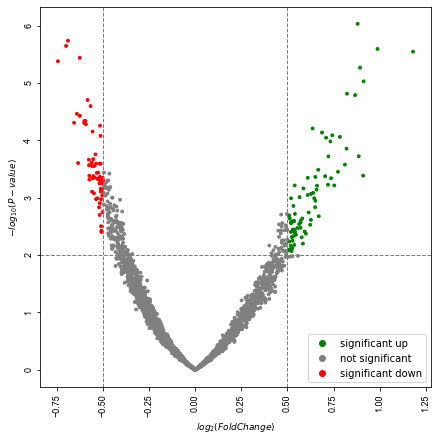

In [200]:
visuz.GeneExpression.volcano(df=volcano, lfc='log2FC', pv='pvalue',
                             #geneid='Genes', genenames='deg',
                             # threshold pair (right, left) always positive
                             lfc_thr=(0.5, 0.5), pv_thr=(0.01, 0.01), 
                             dim=(7,7), sign_line=True, plotlegend=True, show=True)

In [164]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], t_test)

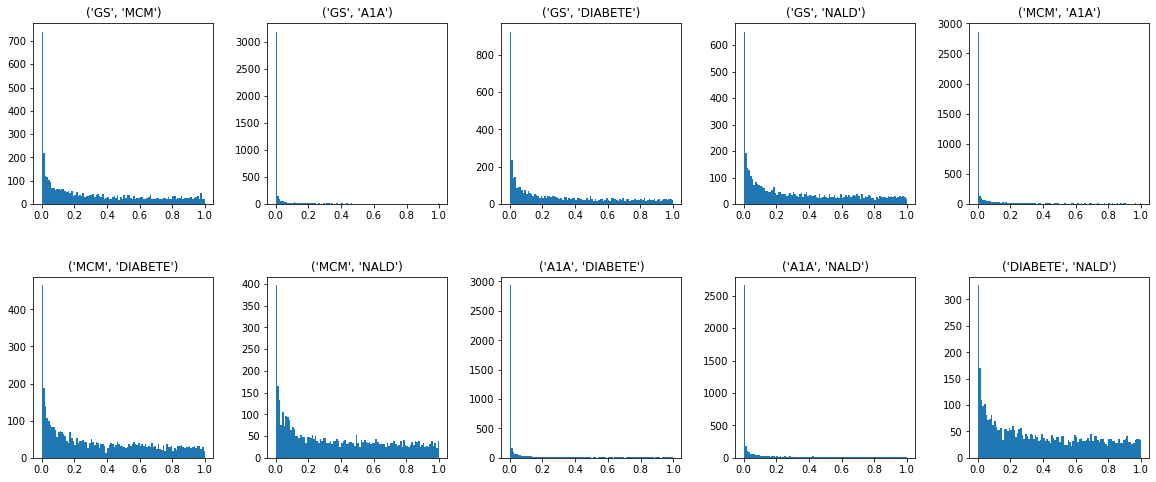

In [165]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].hist(testing[key], bins=100)
    axs[i].set_title(str(key))
    i += 1

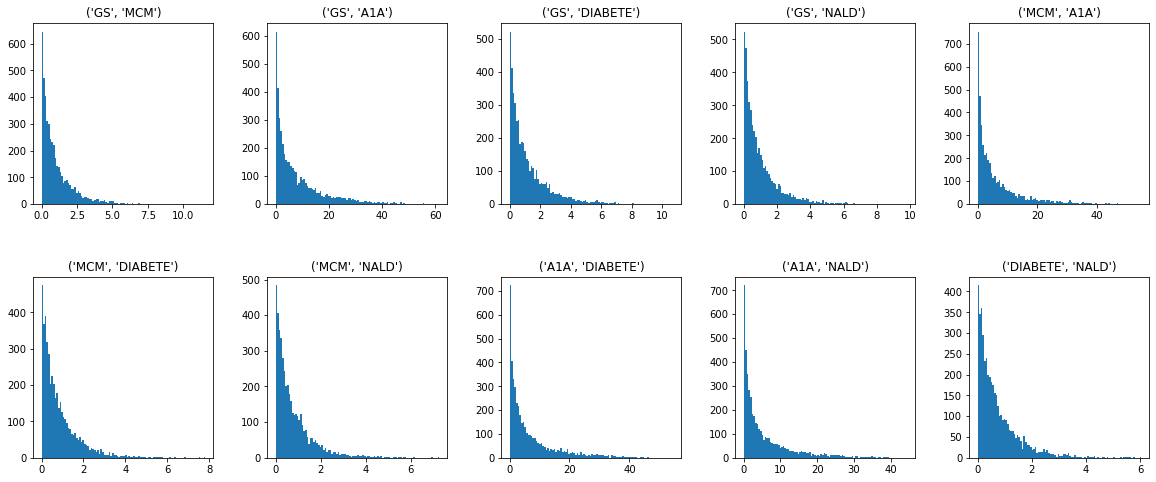

In [166]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

f = lambda x: -math.log(x,10)
i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].hist([f(pval) for pval in value], bins=100)
    axs[i].set_title(str(key))
    i += 1

In [167]:
testing_l2fc = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], log2fc)

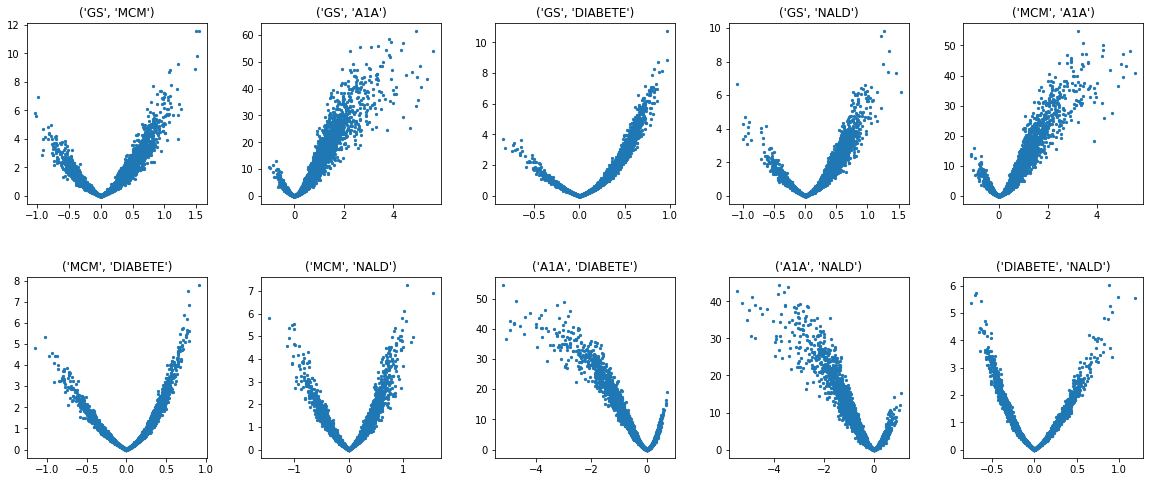

In [168]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .4, wspace=.3)

f = lambda x: -math.log(x,10)
i = 0
axs = axs.ravel()
for key, value in testing.items():
    axs[i].scatter(testing_l2fc[key], [f(pval) for pval in value], s=5)
    axs[i].set_title(str(key))
    i += 1

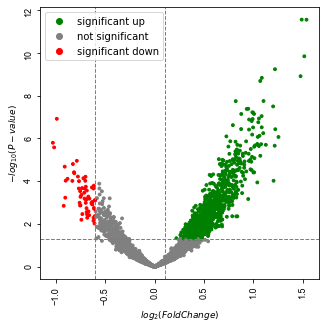

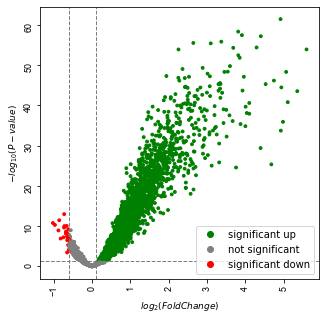

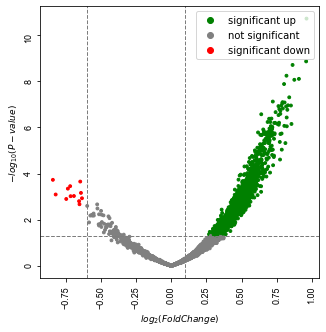

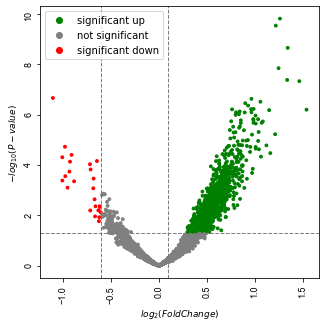

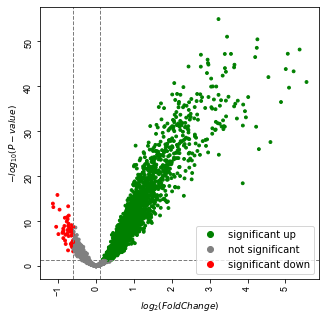

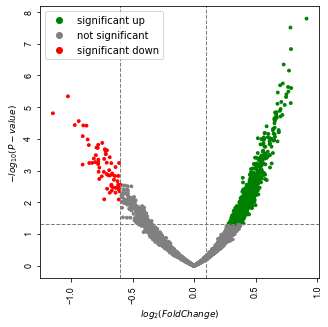

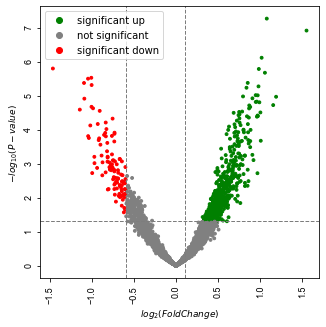

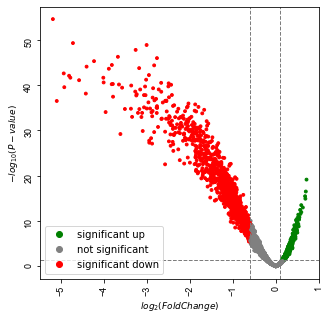

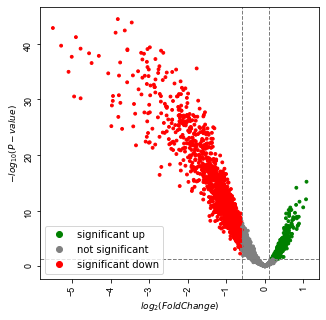

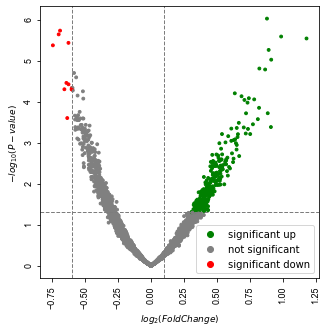

In [201]:
for key, value in testing.items():
    volcano = pd.DataFrame(data={'Genes': data_cols, 'log2FC': testing_l2fc[key], 'pvalue': value})
    visuz.GeneExpression.volcano(df=volcano, lfc='log2FC', pv='pvalue',
                             #geneid='Genes', genenames='deg',
                             # threshold pair (right, left) always positive
                             lfc_thr=(0.1, 0.6), pv_thr=(0.05, 0.05), 
                             figname=str(key), dim=(5,5), sign_line=True, plotlegend=True, show=True)

## Merging test

In [47]:
# Discutere sul perché se faccio pvalue < 0.05 l'intersection è vuota
# Mentre se trasformo tutto in log10 l'intersection non è vuota
# Discutere se va fatto pValue < alpha o pValue > alpha
# In caso di log10 pValue > alpha, senza

In [148]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05, '2fc', testing_l2fc, 0.1)

In [149]:
intersection = gene_intersection(genes_dict)

1461
1262
863
597
400
95
41
34
25
2


In [150]:
len(intersection)

2

# T-test

In [202]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], t_test)

In [208]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05)

In [209]:
intersection = gene_intersection(genes_dict)

1299
1099
703
472
309
42
16
8
7
0


In [210]:
len(intersection)

0

# Wilcoxon test

In [211]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], wilcoxon_test)

In [212]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05)

In [213]:
intersection = gene_intersection(genes_dict)

1403
1176
782
518
325
50
22
11
8
0


In [214]:
len(intersection)

0

# KS test

In [215]:
testing = pairwise_hyp_testing(df, 'DISEASE', ['GS', 'MCM', 'A1A', 'DIABETE', 'NALD'], ks_test)

In [216]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
genes_dict = gene_selection(testing, data_cols, 0.05)

In [217]:
intersection = gene_intersection(genes_dict)

1467
1279
871
599
412
101
45
43
30
4


In [218]:
len(intersection)

4